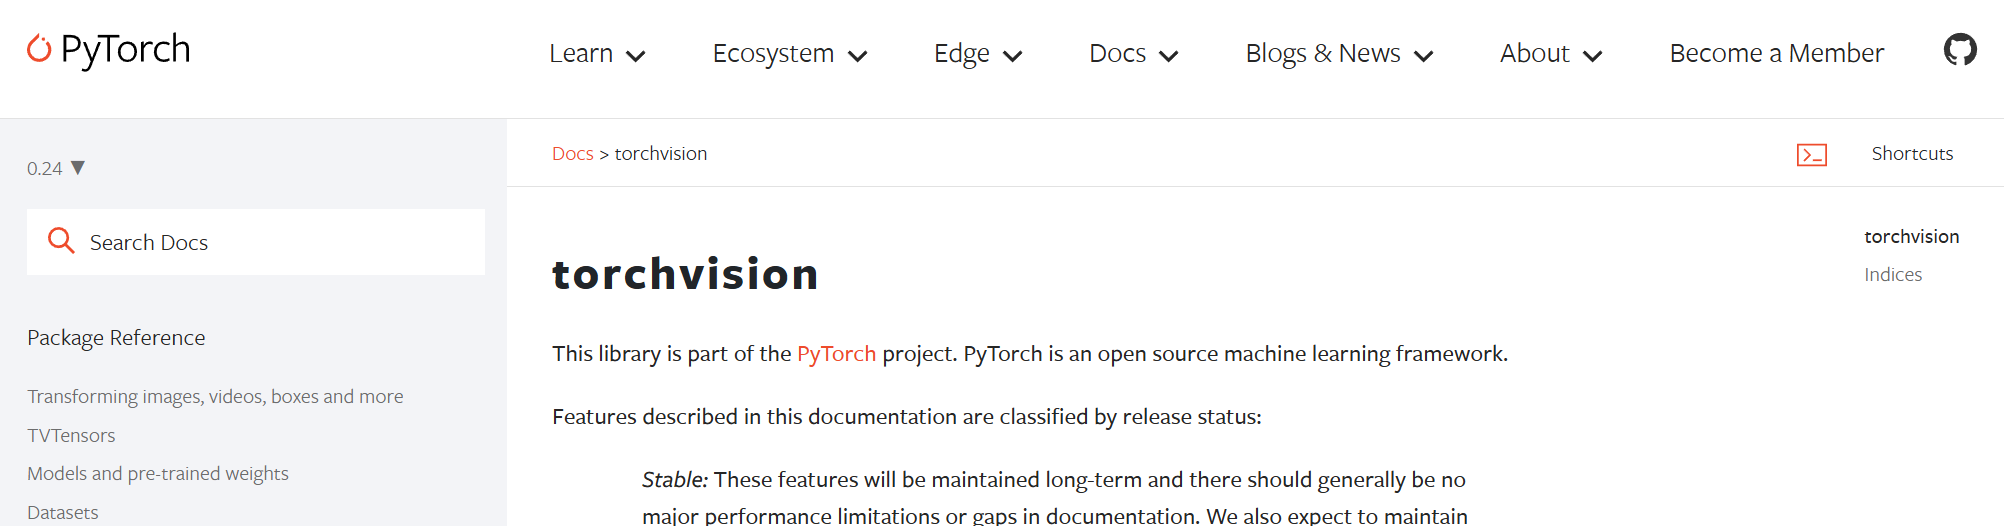

In [20]:
!nvidia-smi

Thu Nov  6 07:52:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              3W /   42W |     126MiB /   8151MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from torchvision import models

Каждый сверточный слой выступает фильтром, который сохраняет нужную информацию, но при этом изображение на входе в слой уменьшается в размере на выходе.

In [3]:
alexnet = models.AlexNet
alexnet

torchvision.models.alexnet.AlexNet

Данная сеть, без весов не будет работать правильно. Нужно либо обучить её, либо использовать эталонные веса.

Прямой проход - это прохождение входного сигнала (данных) через каждый из слоев (вход-выход-вход), до выходного сигнала.

In [7]:
resnet = models.resnet101(weights=True)
# resnet

Предобработка изображений

In [8]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

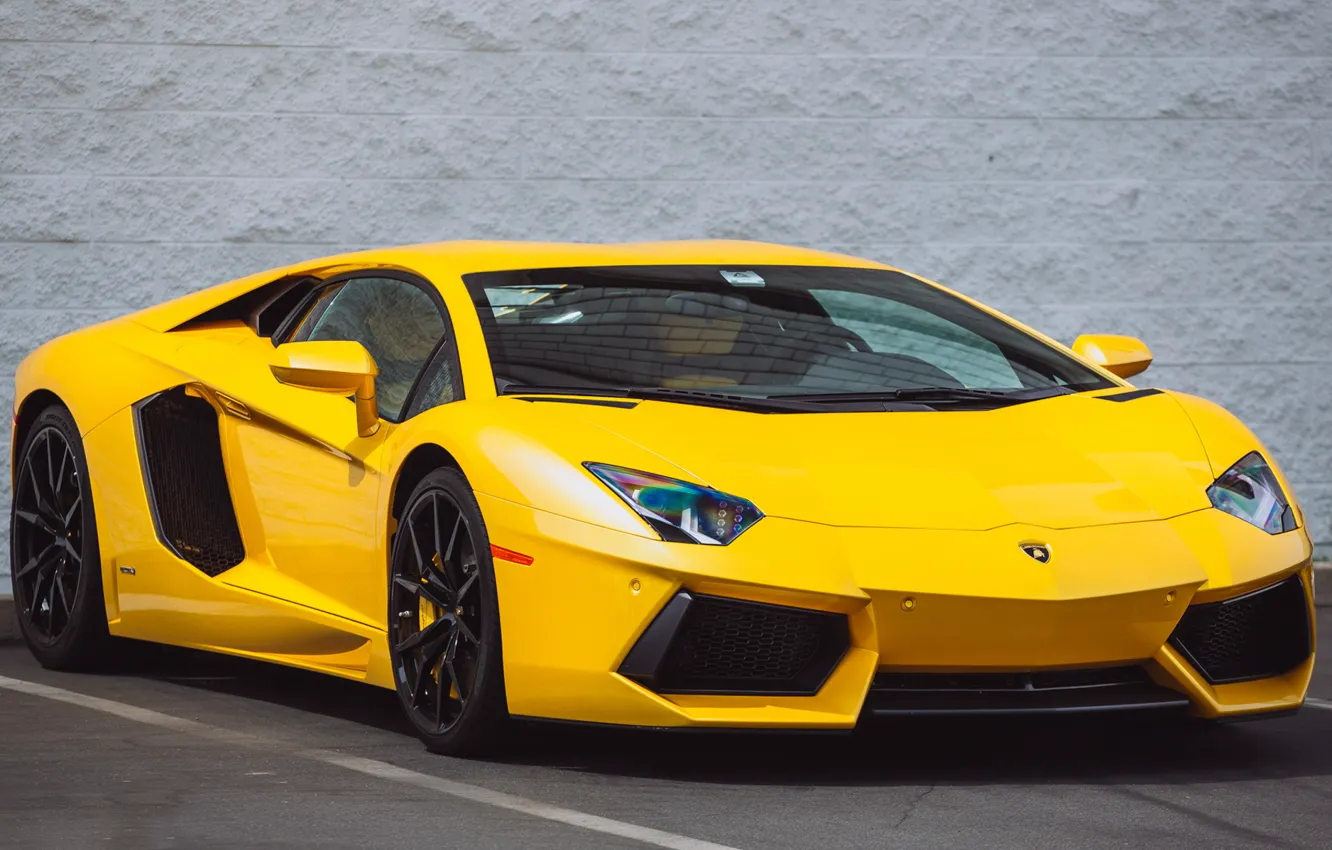

In [11]:
from PIL import Image

img = Image.open("../../images/lamborghini-aventador-yellow.webp")
img

In [13]:
img.show()  # Window with image

In [17]:
img_g = preprocess(img)
img_g.shape

torch.Size([3, 224, 224])

Вставим четвертую ось спереди

In [19]:
batch_g = torch.unsqueeze(img_g, 0)
batch_g.shape

torch.Size([1, 3, 224, 224])

Процесс выполнения обученной модели на новых данных в Deep Learning называется **инференсом (inference)**. Для выполнения инференса необходимо перевести сеть в режим eval. Без eval предобученные модели не сработают как надо.

In [26]:
resnet.eval()
out = resnet(batch_g)
out.shape

torch.Size([1, 1000])

In [27]:
out.argmax()

tensor(817)

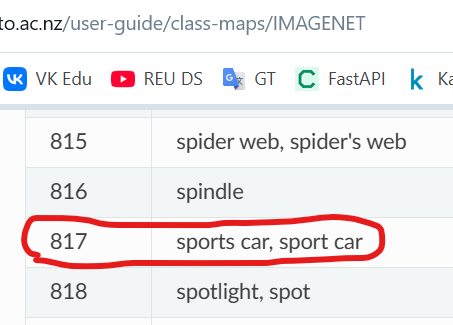

In [ ]:
# Labels for the ImageNet
with open("../../data/ImageNet/imagenet_classes.txt") as file:
    labels = [line.strip() for line in file.readlines()]